# Explore Spritual World Using NLP (Natural Language Processing)

#### This notebook will demonstrate how to explore spritual world using NLP techniques like, sentiment analysis, topic modeling, information retrieval and text summarization.

#### Author: Priyanka Dave

<img src="img.png" title="Explore Spritual World Using NLP" />

### Table of contents:

1. [Explore Datasets](#ed)
    
1. [Data Cleaning & Preprocessing](#dc)
        
1. [Data Visualization](#dv)
        
1. [Sentiment Analysis](#sa)
        
1. [Topic Modeling](#tm)

1. [Fetch Similar Document Using Search Query](#ds)
    
1. [Text Summarization](#ts)

In [1]:
import spacy 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
import pyLDAvis.sklearn
from sklearn.metrics.pairwise import euclidean_distances

from textblob import TextBlob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

In [3]:
nlp.Defaults.stop_words |= {"aries","taurus","gemini","cancer","leo","virgo","libra","scorpio","sagittarius","capricorn","saggitarius","aquarius","pisces","sign","come","go","start",
"1st","2nd","3rd","4th","5th","6th","7th","8th","9th","10th","11th","12th","house","conjunct","degree","astrological","makes","sense","people","vedic","western","happen","understand",
"mercury","venus","earth","mars","jupiter","saturn","uranus","neptune","sun","moon","rahu","ketu","planet","transit","retrograde","north","node","mean","damaged","thing","think",
"ascendent","ascendant","lagna","nakshatra","rashi","natal","chart","shani","sani","sadesati","saati","sade","sati","arudha","conjunction","vid","videos","vedio","vedios","dasha","aspect",
"sir","sirji","astrologer","astrology","video","time","life","year","years","phase","good","like","know","thank","thanks","return",}

In [4]:
articles = pd.read_csv('data/articles.csv')
youtube_comments = pd.read_csv('data/youtube_comments.csv')

# 1. Explore Datasets<a id='ed'>

In [5]:
articles.head(5)

,article_text
0,"During your Saturn return, you are a teenager ..."
1,"The Saturn Return is a wake-up call, and this ..."
2,The effects of the return itself can typically...
3,"Because Saturn is associated with discipline, ..."
4,Saturn in astrology is all about tough love an...


In [6]:
articles.shape

(18, 1)

In [7]:
youtube_comments.head(5)

,Comment,words_count,Likes,Time
0,Anyone here for Saturn return happening in 2020🤞🙃,8.0,173,1 year ago
1,"Honestly, at 28-31 if you dont feel the need t...",176.0,76,3 years ago
2,28 at the moment. 29 in October. Saturn in aq...,12.0,12,9 months ago
3,I had mine in my 6th house I started questioni...,61.0,60,3 years ago
4,thanks for hitting the like button :D,7.0,23,6 years ago


In [8]:
youtube_comments.shape

(1856, 4)

# 2. Data Cleaning & Preprocessing<a id='dc'>

### 1. Data Cleaning
#### Let's remove YouTube comment having words count less or equal to 10 as it is not carrying any information related to topic.

In [9]:
youtube_comments[youtube_comments['words_count'].between(0,10)]

,Comment,words_count,Likes,Time
0,Anyone here for Saturn return happening in 2020🤞🙃,8.0,173,1 year ago
4,thanks for hitting the like button :D,7.0,23,6 years ago
14,I would love to meet you in person!,8.0,13,4 years ago
16,One of the best videos dude !,7.0,17,6 years ago
17,Saturn will be going over my Saturn 6th house.,9.0,4,6 years ago
...,...,...,...,...
1851,Best Explanation regarding sadesati,4.0,1,1 month ago
1852,I like it,3.0,1,2 years ago
1853,You are great,3.0,0,1 month ago
1854,जय जिनेन्द्र,2.0,0,3 months ago


In [10]:
youtube_comments = youtube_comments[youtube_comments['words_count']>10]

In [11]:
youtube_comments.shape

(1260, 4)

### 2. Data Preprocessing

In [12]:
# function to preprocess text data
def preprocessData(docs):
    cleaned_text = []
    keep_pos = ['NOUN', 'ADJ', 'VERB',"ADV"]
    
    for doc in docs:
        doc = nlp(doc.lower())
        data = " ".join([token.lemma_ for token in doc])                      # lemmatization
        data = " ".join(
                                    [str(token) for token in nlp(data) if 
                                     (token.is_punct == False and            # remove punctuations
                                      token.is_stop == False and             # remove STOPWORDS
                                      token.is_oov == False and              # filter non-dictionary words
                                      len(token) > 3 and                     # keep words having char length > 3
                                      token.pos_ in keep_pos)]               # filter text using POS tags
                                    )
                            
        if(len(data)>=5):
            cleaned_text.append(data)  # Keep documents having minimum 5 words
                           
        
    return cleaned_text

In [13]:
articles_data = articles['article_text'].values.tolist()
youtube_data = youtube_comments['Comment'].values.tolist()

In [14]:
cleaned_articles_data = preprocessData(articles_data)
cleaned_youtube_data = preprocessData(youtube_data)

In [15]:
print("Final Document count in Articles: ",len(cleaned_articles_data))
print("Final Document count in YouTube Comments: ",len(cleaned_youtube_data))

Final Document count in Articles:  18
Final Document count in YouTube Comments:  1185


# 3. Data Visualization<a id='dv'>

### 1. Word Cloud

In [16]:
# function to generate word cloud
def generate_wordcloud(corpus,name):
    wordcloud = WordCloud(width=800, height=300,     # height & width of word cloud
                          background_color="white",  # background color of word cloud
                          max_words=1000,            # it will consider only top 1000 words from given corpus to generate word cloud
                          contour_width=10, contour_color='steelblue')
    
    wordcloud.generate(corpus)
    wordcloud.to_file("output/"+name)
    return wordcloud.to_image()

###  Word Cloud of Articles

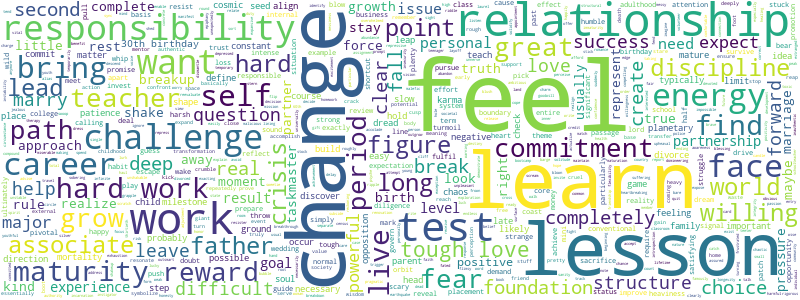

In [17]:
generate_wordcloud(','.join(cleaned_articles_data),'articles_wc.png')

###  Word Cloud of YouTube Comments

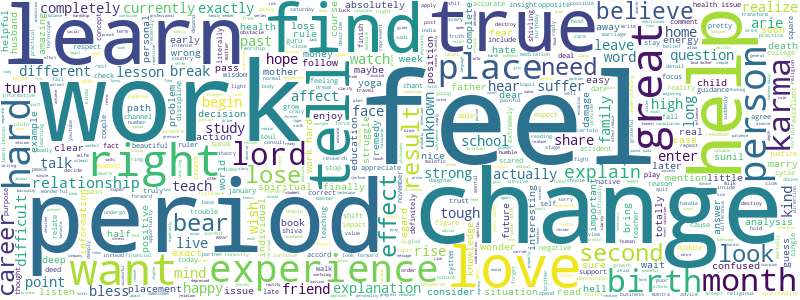

In [18]:
generate_wordcloud(','.join(cleaned_youtube_data),'youtube_comments_wc.png')

### 2. N-gram visualization

In [19]:
# function to generate N-grams
def getTopNGrams(corpus, n, ngram, title):
    
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    dtm = vectorizer.fit_transform(corpus)

    # create and export dataframe document-term matrix
    dtm_dataframe=pd.DataFrame(dtm.toarray(),columns=vectorizer.get_feature_names())
    dtm_dataframe.to_csv("output/"+title+"_"+str(ngram)+"_grams.csv",index=False)
    
    # sum of weights of each word and get top n words
    sum_words = dtm.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    common_words = words_freq[:n]
    
    df = pd.DataFrame(common_words, columns = [title , 'Count'])
    df = df.sort_values(by='Count',ascending=False)
    
    # plot words and frequency using bar plots
    fig = plt.figure()
    df.plot(kind='bar',color='green',x=title)
    plt.title(title)
    plt.xticks(rotation=45,ha="right")
    
    return vectorizer,dtm

### N-gram visualization of Articles

<Figure size 720x360 with 0 Axes>

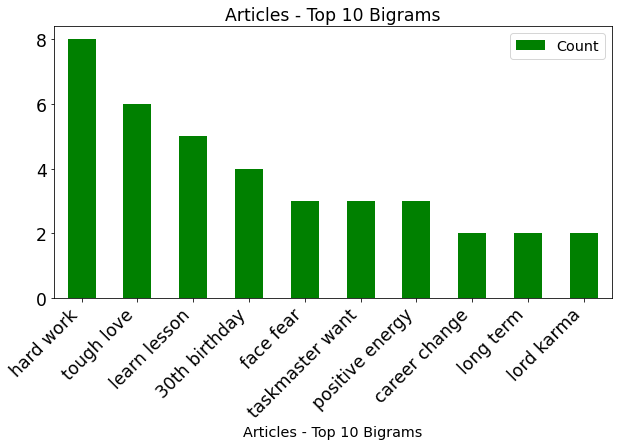

In [20]:
articles_vectorizer,articles_dtm = getTopNGrams(cleaned_articles_data, 10, 2, 'Articles - Top 10 Bigrams')

### N-gram visualization of YouTube Comments

<Figure size 720x360 with 0 Axes>

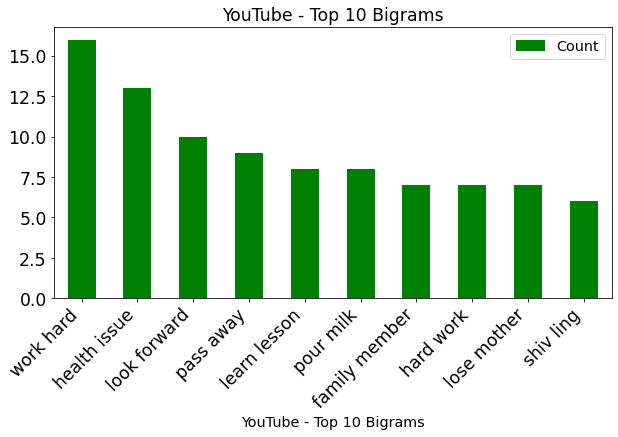

In [21]:
youtube_vectorizer, youtube_dtm = getTopNGrams(cleaned_youtube_data, 10, 2, 'YouTube - Top 10 Bigrams')

# 4. Sentiment Analysis<a id='sa'>

### Articles Sentiment Analysis

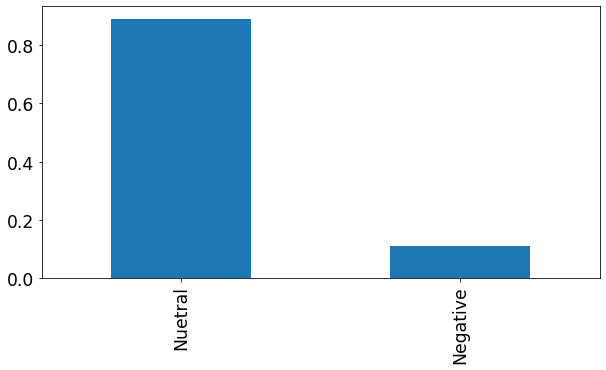

In [22]:
articles['sentiment_score'] = articles['article_text'].apply(lambda text: TextBlob(text).polarity)
articles['sentiment'] = articles['sentiment_score'].apply(lambda sentiment_score: 'Positive' if (sentiment_score>0.5) else 'Negative' if (sentiment_score<0) else 'Nuetral')
articles['sentiment'].value_counts(normalize=True).plot(kind='bar');

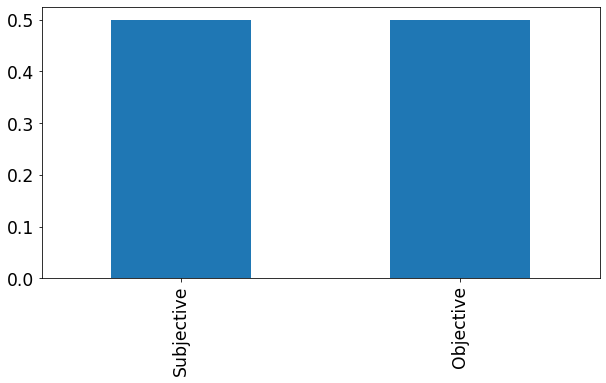

In [23]:
articles['subjectivity_score'] = articles['article_text'].apply(lambda text: TextBlob(text).subjectivity)
articles['subjective_or_objective'] = articles['subjectivity_score'].apply(lambda subjectivity_score: 'Objective' if (subjectivity_score<0.5) else 'Subjective')
articles['subjective_or_objective'].value_counts(normalize=True).plot(kind='bar');

In [24]:
articles.head(5)

,article_text,sentiment_score,sentiment,subjectivity_score,subjective_or_objective
0,"During your Saturn return, you are a teenager ...",0.059259,Nuetral,0.616667,Subjective
1,"The Saturn Return is a wake-up call, and this ...",0.127042,Nuetral,0.496697,Objective
2,The effects of the return itself can typically...,0.071910,Nuetral,0.505906,Subjective
3,"Because Saturn is associated with discipline, ...",-0.064747,Negative,0.508182,Subjective
4,Saturn in astrology is all about tough love an...,0.083142,Nuetral,0.557749,Subjective


### YouTube Sentiment Analysis

<AxesSubplot:>

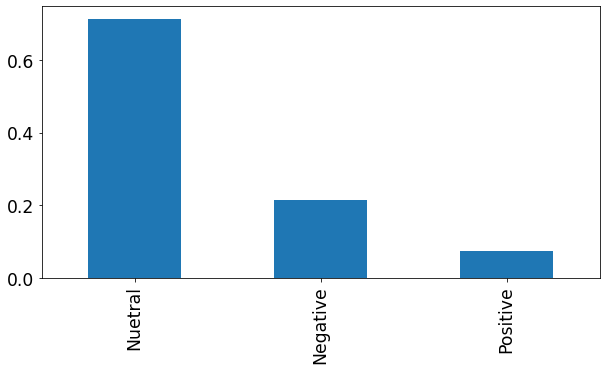

In [25]:
youtube_comments['sentiment_score'] = youtube_comments['Comment'].apply(lambda Comment: TextBlob(Comment).polarity)
youtube_comments['sentiment'] = youtube_comments['sentiment_score'].apply(lambda sentiment_score: 'Positive' if (sentiment_score>0.5) else 'Negative' if(sentiment_score<0) else 'Nuetral')
youtube_comments['sentiment'].value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:>

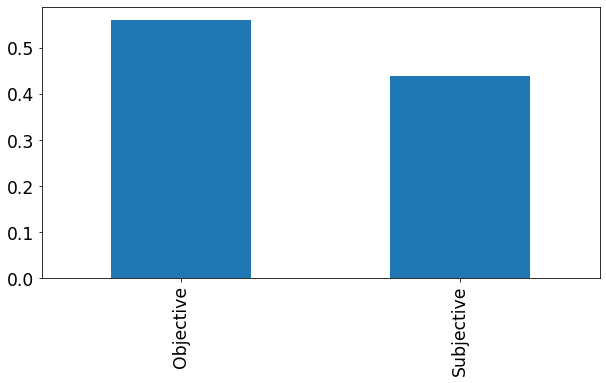

In [26]:
youtube_comments['subjectivity_score'] = youtube_comments['Comment'].apply(lambda Comment: TextBlob(Comment).subjectivity)
youtube_comments['subjective_or_objective'] = youtube_comments['subjectivity_score'].apply(lambda subjectivity_score: 'Objective' if (subjectivity_score<0.5) else 'Subjective')
youtube_comments['subjective_or_objective'].value_counts(normalize=True).plot(kind='bar')

In [27]:
youtube_comments.head(5)

,Comment,words_count,Likes,Time,sentiment_score,sentiment,subjectivity_score,subjective_or_objective
1,"Honestly, at 28-31 if you dont feel the need t...",176.0,76,3 years ago,0.001299,Nuetral,0.486039,Objective
2,28 at the moment. 29 in October. Saturn in aq...,12.0,12,9 months ago,0.000000,Nuetral,0.000000,Objective
3,I had mine in my 6th house I started questioni...,61.0,60,3 years ago,0.145960,Nuetral,0.562049,Subjective
5,I entered my Saturn return this year. I've bee...,122.0,12,1 year ago (edited),0.171852,Nuetral,0.699259,Subjective
6,When I turned 28 I felt that I have finally cl...,97.0,37,3 years ago,0.270170,Nuetral,0.530429,Subjective


# 5. Topic Modeling<a id='tm'>

### 1. Find best LDA Model parameters using GridSearchCV

In [28]:
# function to find best LDA model parameters
def find_best_model(dtm):
    
    search_params = {'n_components': [7,10], 
                     'learning_decay': [0.3], 
                     'batch_size':[5,7], 
                     'random_state':[0]}
    
    lda = LatentDirichletAllocation()
    model = GridSearchCV(lda, param_grid=search_params)
    model.fit(dtm)
    return model.best_estimator_

### Find best model for Articles

In [29]:
#LatentDirichletAllocation(batch_size=5, n_components=5)
articles_model = find_best_model(articles_dtm)
articles_lda_output = articles_model.transform(articles_dtm)
articles_model

LatentDirichletAllocation(batch_size=5, learning_decay=0.3, n_components=7,
                          random_state=0)

### Find best model for YouTube Comments

In [30]:
#LatentDirichletAllocation(batch_size=5, learning_decay=0.3, n_components=5)
youtube_model = find_best_model(youtube_dtm)
youtube_lda_output = youtube_model.transform(youtube_dtm)
youtube_model

LatentDirichletAllocation(batch_size=5, learning_decay=0.3, n_components=7,
                          random_state=0)

## 2. Visualize Topic Keywords

In [31]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for w in lda_model.components_:
        top_keyword_locs = (-w).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    df = pd.DataFrame(topic_keywords)
    df.columns = ['Word '+str(i) for i in range(df.shape[1])]
    df.index = ['Topic '+str(i) for i in range(df.shape[0])]
    return df

### Articles Topic Keywords

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(articles_model, articles_dtm, articles_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -29.594002  60.112713       1        1  23.668441
4     -45.996586  11.891685       2        1  21.238707
1      20.368856  70.019325       3        1  16.376379
5      53.928768  31.704309       4        1  12.975864
6     -12.437127 -26.423267       5        1  10.057473
3       3.965971  21.797720       6        1   7.871838
2      37.524284 -16.517805       7        1   7.811298, topic_info=                 Term      Freq     Total Category  logprob  loglift
656         hard work  4.000000  4.000000  Default  30.0000  30.0000
782      learn lesson  2.000000  2.000000  Default  29.0000  29.0000
224      clear signal  1.000000  1.000000  Default  28.0000  28.0000
1059  positive energy  2.000000  2.000000  Default  27.0000  27.0000
1402  taskmaster want  2.000000  2.000000  Default  26.0000  26.0000
...               ...       ...       ...      ...      ...      ...
516         feel lead  0.415592  0.852659   Topic7  -5.7346   1.8309
782      learn lesson  1.142907  2.431256   Topic7  -4.7229   1.7948
471       face crisis  0.415596  1.338547   Topic7  -5.7345   1.3800
0       30th birthday  0.415595  2.602256   Topic7  -5.7345   0.7152
305      crisis point  0.415594  1.458982   Topic7  -5.7346   1.2938

[268 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         1  0.384282   30th birthday
0         4  0.384282   30th birthday
2         2  0.912959  abandon mature
10        3  0.967077   achieve dream
23        3  0.967077     advise fall
...     ...       ...             ...
1443      4  0.286588      tough love
1519      4  0.684560      want learn
1537      4  0.714364    willing work
1563      1  0.622372       work want
1563      4  0.622372       work want

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 6, 7, 4, 3])

In [33]:
articles_keywords_df = show_topics(vectorizer=articles_vectorizer, lda_model=articles_model, n_words=10)   
articles_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,30th birthday,authentic self,create space,expand feel,expect experience,experience coming,experience deep,experiment play,explore depth,feel allow
Topic 1,lord karma,long term,fall apart,change necessary,fear deep,true destiny,father swoop,career review,fated relationship,track create
Topic 2,learn lesson,face crisis,30th birthday,crisis point,build shape,occur half,likely feel,offer reward,outgrow invite,parent friend
Topic 3,energy feel,associate maturity,lesson learn,great teacher,tough love,basis mini,professor lesson,different great,discipline structure,period undergo
Topic 4,hard work,positive energy,energy hard,level maturity,face challenge,change leap,blessing chaos,instability second,foundation expose,blown reckoning
Topic 5,tough love,taskmaster want,want learn,learn difficult,lesson forward,maybe question,challenge face,repeatedly prove,essentially test,question test
Topic 6,clear signal,tough love,willing work,result satisfying,career change,face fear,reward effort,feel stuck,resist change,demonstrate commitment


### YouTube Topic Keywords

In [34]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(youtube_model, youtube_dtm, youtube_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -29.594002  60.112713       1        1  16.755530
6     -45.996586  11.891685       2        1  15.383772
5      20.368856  70.019325       3        1  14.241329
3      53.928768  31.704309       4        1  13.866891
1     -12.437127 -26.423267       5        1  13.383784
2       3.965971  21.797720       6        1  13.375735
0      37.524284 -16.517805       7        1  12.992958, topic_info=                      Term      Freq     Total Category  logprob  loglift
7307             pour milk  4.000000  4.000000  Default  30.0000  30.0000
10467            work hard  9.000000  9.000000  Default  29.0000  29.0000
10269           wear black  2.000000  2.000000  Default  28.0000  28.0000
2735         effect reduce  3.000000  3.000000  Default  27.0000  27.0000
4115         hanuman daily  3.000000  3.000000  Default  26.0000  26.0000
...                    ...       ...       ...      ...      ...      ...
3142      explanation hear  1.062868  2.015971   Topic7  -7.2551   1.4006
1399         chant hanuman  1.062847  2.027264   Topic7  -7.2551   1.3950
8935   spiritual awakening  1.062839  2.050452   Topic7  -7.2552   1.3836
4536             hope hear  1.062831  2.015972   Topic7  -7.2552   1.4006
3606            find peace  1.062806  2.027266   Topic7  -7.2552   1.3950

[299 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
11         3  0.639101       28th birthday
27         1  0.609419     ability mislead
51         6  0.654550  absolutely believe
56         4  0.488198     absolutely hate
56         5  0.488198     absolutely hate
...      ...       ...                 ...
10534      4  0.645014     worship atleast
10536      4  0.645014     worship hanuman
10573      5  0.492782      wrong decision
10573      7  0.492782      wrong decision
10617      3  0.639101          youth fade

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 6, 4, 2, 3, 1])

In [35]:
youtube_keywords_df = show_topics(vectorizer=youtube_vectorizer, lda_model=youtube_model, n_words=10)   
youtube_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,lose mother,absolutely right,help person,badly place,open possibility,malefic effect,great explanation,explanation hear,chant hanuman,spiritual awakening
Topic 1,family friend,place place,material world,personal issue,wrong decision,look forward,hard work,unknown share,pass away,absolutely hate
Topic 2,mind blow,pour milk,wear black,family member,foreign land,look forward,struggle find,health issue,karma result,establish enlightenment
Topic 3,karma lose,feel change,hanuman worship,totally different,feel strong,club phenomenon,scorpion right,hell hell,feel effect,mangal worship
Topic 4,work hard,hard work,lord shiva,past karma,self realisation,negative thought,decide want,person self,realise mistake,deed past
Topic 5,health issue,shiv ling,learn lesson,milk shiv,pour milk,middle finger,high learning,struggle barely,julian calendar,bear bear
Topic 6,work hard,effect reduce,hanuman daily,reduce negative,blessing hanuman,improve positive,positive effect,hanuman improve,recite hanuman,daily blessing


# 6. Fetch Similar Document Using Search Query<a id='ds'>

### Euclidean distance is the distance between 2 points in a multidimensional space. Closer points are more similar to each other. Further points are more different from each other. 

In [36]:
# function to calculate distance and find document with smallest distance
def similar_documents(text, vectorizer, lda_model, lda_output, topic_keywords_df, documents, nlp, top_n, verbose):
    topic, x  = predict_topic(text, vectorizer, lda_model, nlp, topic_keywords_df)
    dists = euclidean_distances(x.reshape(1, -1), lda_output)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(lda_output[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)


# function to predict topics of search query 
def predict_topic(text, vectorizer, lda_model, nlp, topic_keywords_df):
    cleaned_text = preprocessData(text)
    text_dtm = vectorizer.transform(cleaned_text)
    topic_probability_scores = lda_model.transform(text_dtm)
    topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

In [37]:
search_query = ["tell me something about authentic self"]

### Retrieve similar documnent from Articles

In [38]:
doc_ids, docs = similar_documents(search_query, articles_vectorizer, articles_model, articles_lda_output, articles_keywords_df, articles_data, nlp, 1, True)
print('\n', articles_data[doc_ids[0]])

Topic KeyWords:  ['30th birthday', 'authentic self', 'create space', 'expand feel', 'expect experience', 'experience coming', 'experience deep', 'experiment play', 'explore depth', 'feel allow']
Topic Prob Scores of text:  [[0.6 0.1 0.1 0.1 0.1 0.1 0.1]]
Most Similar Doc's Probs:   [[1. 0. 0. 0. 0. 0. 0.]]

 When Saturn is involved, think: responsibilities, rules, restrictions, obligations, challenges, and lessons. Sometimes tough ones. It’s like a cosmic check-in—and check-up—from the Lord of Karma himself. This is your astrological coming-of-age story. It is important to remember that Saturn’s job is to show you the areas of your life where you are the hardest on yourself. You are being pushed to level up to the next stage of life. After all, Saturn is the planetary taskmaster, and at this time, he will likely hold your feet to the proverbial fire. Consider your life before this moment: You have been restricted by the rules placed on you by your parents, teachers, bosses, mentors, an

### Retrieve similar documnent from YouTube Comments

In [39]:
doc_ids, docs = similar_documents(search_query, youtube_vectorizer, youtube_model, youtube_lda_output, youtube_keywords_df, youtube_data, nlp, 1, True)
print('\n', youtube_data[doc_ids[0]])

Topic KeyWords:  ['work hard', 'hard work', 'lord shiva', 'past karma', 'self realisation', 'negative thought', 'decide want', 'person self', 'realise mistake', 'deed past']
Topic Prob Scores of text:  [[0.1 0.1 0.1 0.1 0.6 0.1 0.1]]
Most Similar Doc's Probs:   [[0.1 0.1 0.1 0.1 0.6 0.1 0.1]]

 you can do everything man!! but now u  really doing your best.... of course its all depend on karmas but finally you listened your soul which must  be key ruling  in your chart which is sun !!  your fame is near to success for sure. tnx


# 7. Text Summarization<a id='ts'>

In [40]:
from summarizer import Summarizer
model = Summarizer()

In [41]:
youtube_comments_body = " ".join(youtube_comments['Comment'])
articles_body = " ".join(articles['article_text'])

In [42]:
yt_num_of_sent = model.calculate_optimal_k(youtube_comments_body, k_max=5)
at_num_of_sent = model.calculate_optimal_k(articles_body, k_max=5)

In [43]:
youtube_comments_summary = model(youtube_comments_body, num_sentences=yt_num_of_sent)
articles_summary = model(articles_body, num_sentences=at_num_of_sent)

In [44]:
print("YouTube Summary:\n")
print(youtube_comments_summary)
print("-----------\n")
print("Articles Summary:\n")
print(articles_summary)

In [ ]:
youtube_comments_summary_ratio = model(youtube_comments_body, ratio=0.05)
articles_summary_ratio = model(articles_body, ratio=0.01)

In [ ]:
print("YouTube Summary:\n")
print(youtube_comments_summary_ratio)
print("-----------\n")
print("Articles Summary:\n")
print(articles_summary_ratio)

# Thank You